pre-trained word embadding (word2vec)

In [42]:
import re
import pandas as pd
from konlpy.tag import Okt

##https://stackoverflow.com/의 데이터를 크롤링해 저장한 파일
crawling_data = pd.read_csv('crawling_result.csv', sep=",", keep_default_na=False)

tokenize_text = []

for idx, member in crawling_data.iterrows():
    okt=Okt()
    try:
        if member[0] is not None:
            okt = okt.pos(member[0].lower())
            word_list = [n for n, tag in okt if tag == 'Alpha' and len(n) >= 2]
    except:
        print("error : " + m)
        print(member[0])
    
    if(len(word_list) >= 2):
        tokenize_text.append(word_list)
    

print('총 토큰 개수 : {}'.format(len(tokenize_text)))

총 토큰 개수 : 52841


In [3]:
#Word2Vec 훈련
from gensim.models import Word2Vec
embadding_size = 32
model = Word2Vec(sentences=tokenize_text,size=embadding_size, window=5, min_count=3, workers=4, sg=0)

In [4]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

------------------------ 미리 저장된 모델 로드  -----------------------------

In [11]:
from gensim.models import KeyedVectors
embadding_size = 32
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [12]:
model_result = loaded_model.most_similar("iostream") #word embedding 확인
print(model_result)

[('ctime', 0.9325694441795349), ('namespace', 0.9204610586166382), ('sstream', 0.8891147375106812), ('iomanip', 0.8835949897766113), ('cstdio', 0.8781796097755432), ('algorithm', 0.8671043515205383), ('hpp', 0.8418859839439392), ('bitset', 0.8048309087753296), ('cassert', 0.7983977198600769), ('cstdlib', 0.7979016304016113)]


In [2]:
import re
import pandas as pd
from konlpy.tag import Okt ##한국어 NLP인 KoNLPy 사용

word_cnt = []
vocab = {}

train_data_read = pd.read_csv('hashcode_classification2020_train.csv', sep=",", keep_default_na=False)

train_data = []
train_y = []
cnt = 0

for idx, member in train_data_read.iterrows():
    
        ## 훈련 데이터의 파일의 문장들을 분석하여 저장
        for i in range(2):
            okt=Okt()
            try:
                if member[i] is not None:
                    okt = okt.pos(member[i].lower())
                    word_list = [n for n, tag in okt if tag == 'Alpha' and len(n) >= 2]
            except:
                print("error : " + m)
                print(member[i])
        cnt += len(word_list)
        train_data.append(word_list)
        train_y.append(member[2])
        
        ## 훈련 데이터 파일의 단어가 나온 횟수를 저장 (정수 인코딩)
        for word in word_list:
            if word not in vocab:
                vocab[word] = 0
            vocab[word] += 1
                


In [3]:
test_data_read = pd.read_csv('hashcode_classification2020_test.csv', sep=",")
test_data = []

##테스트 데이터의 파일의 문장들을 분석하여 저장
for idx, member in test_data_read.iterrows():
        for i in range(2):
            okt=Okt()
            try:
                okt = okt.pos(member[i].lower())
                word_list = [n for n, tag in okt if tag == 'Alpha' and len(n) >= 2]
            except:
                print("error")
        
        test_data.append(word_list)
        


In [4]:
#단어 빈도수 순으로 정렬
vocab_sorted=sorted(vocab.items(), key=lambda x:x[1], reverse=True)

print("단어 종류 : {}".format(len(vocab_sorted)))

word_index={}
index_max = 784

i = 0
for (word, frequency) in vocab_sorted:
    if frequency > 2 and i < index_max and len(word) != 1:
        i += 1
        word_index[word] = i
        
        

단어 종류 : 10902


In [5]:
#정수 인코딩
train_x = []
for s in train_data:
    temp = []
    for word in s:
        try:
            temp.append(word_index[word])
        except:
            temp.append(index_max + 1)
    train_x.append(temp)
    
real_test_x = []
for s in test_data:
    temp = []
    for word in s:
        try:
            temp.append(word_index[word])
        except:
            temp.append(index_max + 1)
    real_test_x.append(temp)


In [6]:
#train 데이터의 20퍼센트 가량을 테스트 데이터로 사용
p_test_x = train_x [2074:]
p_train_x = train_x [:2073]

p_test_y = train_y [2074:]
p_train_y = train_y [:2073]


In [7]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

max_len = 100
p_train_x = pad_sequences(p_train_x, maxlen=max_len) # 훈련용 뉴스 기사 패딩
p_test_x = pad_sequences(p_test_x, maxlen=max_len) # 테스트용 뉴스 기사 패딩

p_train_y = to_categorical(p_train_y) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
p_test_y = to_categorical(p_test_y) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩

In [13]:
import numpy as np
embedding_matrix = np.zeros((index_max+2, embadding_size))
# 단어 집합 크기의 행과 300개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.


#pre-trained word embedding을 사용하기 위한 함수
def get_vector(word):
    if word in loaded_model:
        return loaded_model[word]
    else:
        return None

for word, i in word_index.items(): 
    temp = get_vector(word) 
    if temp is not None: 
        embedding_matrix[i] = temp 



In [36]:
## 자연어 처리에 주로 사용되는 모델인 RNN 사용, 입력된 데이터가 다음시점에 자신에게 영향을 줌으로써 적응이 빠름
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(index_max+2, embadding_size, weights=[embedding_matrix], input_length=max_len, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embadding_size)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])


model.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])

## 훈련 데이터를 통한 모델 검증
history = model.fit(p_train_x, p_train_y, batch_size=128, epochs=20, validation_data=(p_test_x, p_test_y))

Train on 2073 samples, validate on 518 samples
Epoch 1/20
2073/2073 [==============================] - 9s 4ms/sample - loss: 1.7828 - accuracy: 0.2629 - val_loss: 1.6409 - val_accuracy: 0.4093
Epoch 2/20
2073/2073 [==============================] - 2s 1ms/sample - loss: 1.5946 - accuracy: 0.3912 - val_loss: 1.4947 - val_accuracy: 0.4305
Epoch 3/20
2073/2073 [==============================] - 2s 1ms/sample - loss: 1.4511 - accuracy: 0.4317 - val_loss: 1.3790 - val_accuracy: 0.4421
Epoch 4/20
2073/2073 [==============================] - 2s 1ms/sample - loss: 1.3458 - accuracy: 0.4867 - val_loss: 1.2819 - val_accuracy: 0.4981
Epoch 5/20
2073/2073 [==============================] - 2s 1ms/sample - loss: 1.2594 - accuracy: 0.5215 - val_loss: 1.1979 - val_accuracy: 0.5367
Epoch 6/20
2073/2073 [==============================] - 2s 1ms/sample - loss: 1.1889 - accuracy: 0.5470 - val_loss: 1.1481 - val_accuracy: 0.5753
Epoch 7/20
2073/2073 [==============================] - 2s 1ms/sample - loss:

In [37]:
#테스트 데이터 예측
real_test_x = pad_sequences(real_test_x, maxlen=max_len)
result = model.predict(real_test_x)

In [38]:
#예측한 결과값을 decoding 
import numpy as np
decode = np.argmax(result, axis=1)
print(decode)

[5 4 1 3 5 3 4 4 3 3 2 5 5 3 5 3 4 1 1 2 3 5 3 5 1 4 5 2 5 3 4 3 4 4 3 5 3
 4 4 5 1 5 3 3 4 1 3 3 4 5 4 3 1 1 1 2 5 5 3 5 3 3 5 3 4 5 3 4 3 3 3 5 3 3
 4 4 4 5 2 3 3 1 5 4 5 4 2 5 3 3 3 1 3 3 1 2 1 3 5 4 3 3 3 2 2 1 4 4 2 4 2
 1 4 3 3 5 4 4 3 2 2 2 4 1 3 3 3 1 1 5 2 1 2 5 4 3 5 3 3 3 5 5 5 5 3 3 4 4
 3 5 4 3 1 3 3 5 2 4 3 4 3 3 5 4 2 3 3 3 3 5 1 5 5 5 3 2 4 2 4 4 4 3 5 5 2
 3 5 1 3 2 1 4 5 3 4 4 4 4 1 4 1 3 3 5 3 2 5 5 3 4 1 1 2 3 1 5 1 5 3 4 5 3
 4 3 3 2 5 5 3 3 3 3 4 1 2 3 5 1 5 2 4 3 5 2 1 4 4 1 1 3 1 3 1 2 3 4 4 3 3
 3 3 3 3 1 5 5 3 5 3 3 1 5 3 3 4 1 2 4 1 1 3 5 1 1 5 1 3 3 5 3 1 2 5 1 4 4
 1 3 5 1 1 5 3 3 3 3 3 5 3 3 5 5 2 5 3 2 3 5 3 3 4 3 2 3 3 3 3 3 5 3 2 4 3
 3 3 2 4 3 3 5 3 5 3 3 3 1 3 1 5 5 4 5 3 2 1 3 3 5 3 5 5 3 3 3 3 1 3 1 4 2
 3 3 4 1 5 3 1 3 4 3 5 3 3 3 3 5 3 1 4 2 4 1 3 5 5 3 3 5 1 2 3 5 1 1 3 4 3
 5 3 4 1 5 5 3 3 4 4 2 1 3 5 3 3 3 3 3 3 3 2 3 5 3 4 3 4 5 3 4 2 3 3 5 3 2
 4 4 4 2 3 1 3 3 4 4 1 3 4 3 3 3 4 4 5 3 3 3 3 3 1 1 5 3 5 2 5 2 3 4 4 4 5
 5 3 5 5 2 3 5 2 5 3 5 3 

In [39]:
df = pd.DataFrame(decode, columns=['label'])

In [40]:
df.to_csv('./result.csv', index=False)

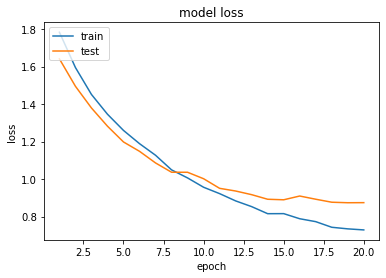

In [41]:
#정확도와 손실값을 표현
import matplotlib.pyplot as plt
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()